In [1]:
import blackjack_original as jack
import blackjack_double as jack_double
import blackjack_deckofcard as jack_countdeck

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

from tqdm.notebook import tqdm

#### Наивная стратегия: делать stand при сумме карт 16-21, иначе hit

In [5]:
# 0 - stand
# 1 - hit
env = jack.BlackjackEnv(natural=True)

episods = 100000
state_stand = [16, 17, 18, 19, 20, 21]
reward_average = 0
step_average = 0

for i in tqdm(range(episods),desc="TRAINING"):
    player, dealer, usable_ace = env.reset()
    done = False
    step=1
    while(done==False):
        step+=1
        if player in state_stand:
            (player, dealer, usable_ace), reward, done, _ = env.step(0)            
        else:
            (player, dealer, usable_ace), reward, done, _ = env.step(1)
    reward_average += reward
    step_average += step
    
reward_average = reward_average/episods
step_average = step_average/episods

print(f"{reward_average} Наивная стратегия: делать stand при сумме {state_stand} среднее кол-во ходов:{step_average}")


-0.055025 Наивная стратегия: делать stand при сумме [16, 17, 18, 19, 20, 21] среднее кол-во ходов:2.55305


#### Off-policy TD control "Q learning"

In [2]:
class TDcontrol():
    def __init__(self, gym_env, epsilon, alpha, gamma):
        self.env = gym_env
        
        A_count = self.env.action_space.n
        S_shape = []
        for space in self.env.observation_space:
            S_shape.append(space.n)
        shape = S_shape
        shape.append(A_count)
        self.Q = np.zeros((shape))
        
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma        
            
    def set(self,):
        pass
    
    def train(self, episods, show_plots = False):        
        if show_plots:
            game_size = 100000
            batch_size = 10000 if episods<1000000 else 50000
            batch_count = episods//batch_size
            x_episods = []
            y_rewards = []           

            for index_batch in range(batch_count):
                self.__trainloop(batch_size, disable_tqdm=True)
                reward_average, _ = self.game(game_size, disable_tqdm=True)
                # графики
                x_episods.append((index_batch+1)*batch_size)
                y_rewards.append(reward_average)
                clear_output(True)
                plt.figure(figsize=(16, 5))
                plt.xlabel('Количество эпизодов обучения')
                plt.ylabel(f'Награда (расчитана как усреднение {game_size} партий.)')
                plt.plot(x_episods, y_rewards, linewidth=1)
                plt.show()
                
                
        else:
            self.__trainloop(episods)

    
    
    def game(self, episods, disable_tqdm=False):
        reward_average = 0
        step_average = 0
        for _ in tqdm(range(episods),desc="GAMING", disable=disable_tqdm):
            state = self.env.reset()
            done = False
            step = 1
            while not(done):
                action = self.pi(state)
                state, reward, done, _ = self.env.step(action)
                step+=1
            reward_average+=reward
            step_average+=step
            
        return reward_average/episods, step_average/episods
                
    def pi(self, state):
        return np.argmax(self.Q[state])
        
    def __get_action(self, state):
        if np.random.uniform(0,1)<self.epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.Q[state])
        
    def __retr(self,player, dealer, usable_ace):
        pass
    
    def __trainloop(self, iterations, disable_tqdm=False):
        for _ in tqdm(range(iterations),desc="TRAINING", disable=disable_tqdm):
            state = self.env.reset()
            done = False
            while not(done):
                action = self.__get_action(state)
                state_new, reward, done, _ = self.env.step(action)
                self.Q[state][action] = self.Q[state][action] + self.alpha*(reward + self.gamma*np.max(self.Q[state_new]) - self.Q[state][action])
                state = state_new

#### Обучение стратегии для простейшего BlackJack Natural с действиями: hit\stand

In [ ]:
env = jack.BlackjackEnv(natural=True)

alphas = [1e-6, 1e-5, 1e-4]
gammas = [0.5, 0.8, 0.9, 1]
epsilons = [0.8, 0.85, 0.9, 0.95]
episods_train = 100000
episods_game = 100000
results = []

for alpha in alphas:
    for gamma in gammas:
        for epsilon in epsilons:
            qmodel = TDcontrol(env, epsilon, alpha, gamma)
            qmodel.train(episods_train)
            rew,_ = qmodel.game(episods_game)
            result = f"{rew} train episods={episods_train} game episods={episods_game} alpha={alpha} gamma={gamma} epsilon={epsilon}"
            results.append(result)
            print("Off-policy TD control (Q learning)")
            print(result)

Результаты перебора гиперпараметров:  
-0.0286625 steps average=2.517175 alpha=1e-05 gamma=0.8 epsilon=0.9  
-0.0221275 steps average=2.509645 alpha=1e-05 gamma=0.9 epsilon=0.9  
-0.0272775 steps average=2.527905 alpha=0.0001 gamma=0.8 epsilon=0.85  
-0.0278525 steps average=2.522095 alpha=0.0001 gamma=0.8 epsilon=0.9  
-0.0279025 steps average=2.51747 alpha=0.0001 gamma=0.9 epsilon=0.85  
-0.027605 steps average=2.518605 alpha=0.0001 gamma=0.9 epsilon=0.95  
-0.0275075 steps average=2.532325 alpha=0.0001 gamma=1 epsilon=0.85  
-0.0270925 steps average=2.495345 alpha=1e-06 gamma=1 epsilon=0.99  
-0.02758 steps average=2.521735 alpha=1e-05 gamma=0.5 epsilon=0.9  
-0.0273425 steps average=2.521985 alpha=0.0001 gamma=0.5 epsilon=0.9  
-0.02724 steps average=2.51686 alpha=0.0001 gamma=0.9 epsilon=0.999  
-0.0275925 steps average=2.5243alpha=0.0001 gamma=1 epsilon=0.9999  

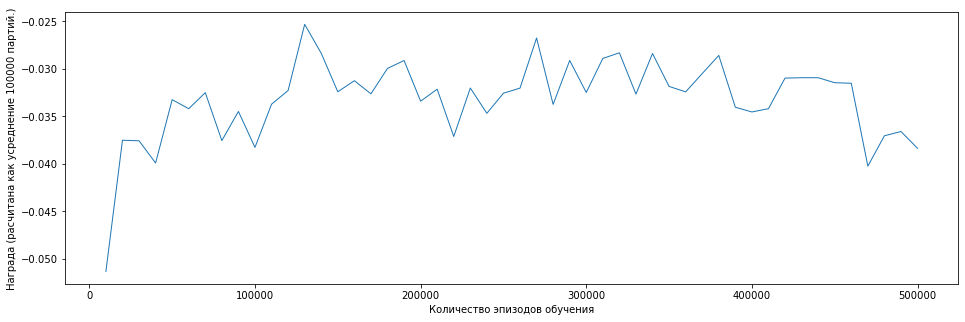


Off-policy TD control (Q learning)
-0.02903 train episods=500000 game episods=100000 alpha=1e-07 gamma=0.9 epsilon=0.9


In [3]:
env = jack.BlackjackEnv(natural=True)
epsilon = 0.9
alpha = 1e-07
gamma = 0.9
episods_train = 500000
episods_game = 100000
qmodel = TDcontrol(env, epsilon, alpha, gamma)

qmodel.train(episods_train, show_plots = True)
rew,_ = qmodel.game(episods_game)
print("Off-policy TD control (Q learning)")
print(f"{rew} train episods={episods_train} game episods={episods_game} alpha={alpha} gamma={gamma} epsilon={epsilon}")

#### Обучение стратегии для BlackJack Natural с действиями: hit\stand\double

In [ ]:
env = jack_double.BlackjackEnv(natural=True)

alphas = [1e-6, 1e-5, 1e-4]
gammas = [0.5, 0.8, 0.9, 1]
epsilons = [0.8, 0.85, 0.9, 0.95]
episods_train = 100000*2
episods_game = 100000

results = []

for alpha in alphas:
    for gamma in gammas:
        for epsilon in epsilons:
            qmodel = TDcontrol(env, epsilon, alpha, gamma)
            qmodel.train(episods_train)
            rew,_ = qmodel.game(episods_game)
            result = f"{rew} train episods={episods_train} game episods={episods_game} alpha={alpha} gamma={gamma} epsilon={epsilon}"
            results.append(result)
            print("Off-policy TD control (Q learning)")
            print(result)

Результаты перебора гиперпараметров:  
-0.0152325 steps average=2.39135 alpha=1e-06 gamma=0.8 epsilon=0.95  
-0.0179575 steps average=2.379765 alpha=1e-06 gamma=1 epsilon=0.85  
-0.0189975 steps average=2.37266 alpha=1e-05 gamma=0.8 epsilon=0.85  

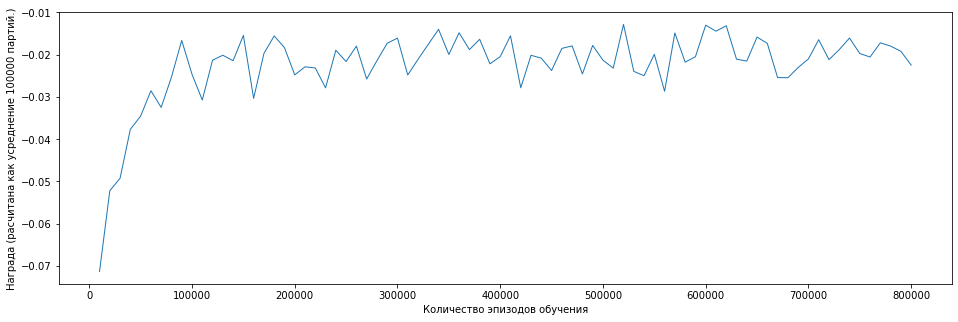


Off-policy TD control (Q learning)
-0.0178 train episods=800000 game episods=100000 alpha=1e-07 gamma=0.8 epsilon=0.95


In [4]:
env = jack_double.BlackjackEnv(natural=True)
epsilon = 0.95
alpha = 1e-07
gamma = 0.8
episods_train = 800000
episods_game = 100000
qmodel = TDcontrol(env, epsilon, alpha, gamma)

qmodel.train(episods_train, show_plots = True)
rew,_ = qmodel.game(episods_game)
print("Off-policy TD control (Q learning)")
print(f"{rew} train episods={episods_train} game episods={episods_game} alpha={alpha} gamma={gamma} epsilon={epsilon}")

#### Обучение стратегии для BlackJack Natural с действиями: hit\stand\double + c подсчетом карт системой «Половинки» 

In [ ]:
env = jack_countdeck.BlackjackEnv(natural=True)

alphas = [1e-6, 1e-5, 1e-4]
gammas = [0.5, 0.8, 0.9, 1]
epsilons = [0.8, 0.85, 0.9, 0.95]
episods_train = 100000*2*89
episods_game = 100000
results = []

for alpha in alphas:
    for gamma in gammas:
        for epsilon in epsilons:
            qmodel = TDcontrol(env, epsilon, alpha, gamma)
            qmodel.train(episods_train)
            rew,_ = qmodel.game(episods_game)
            result = f"{rew} train episods={episods_train} game episods={episods_game} alpha={alpha} gamma={gamma} epsilon={epsilon}"
            results.append(result)
            print("Off-policy TD control (Q learning)")
            print(result)

Результаты перебора гиперпараметров:  
-0.024049 steps average=2.348 train\game episods=1500000 alpha=2e-05 gamma=1 epsilon=1  
-0.011602 steps average=2.367 train\game episods=9000000 alpha=2e-05 gamma=1 epsilon=1  
-0.008165 train episods=10000000 game episods=100000 alpha=1e-07 gamma=0.9 epsilon=0.95  
-0.009315 train episods=10000000 game episods=100000 alpha=1e-07 gamma=1 epsilon=0.99  

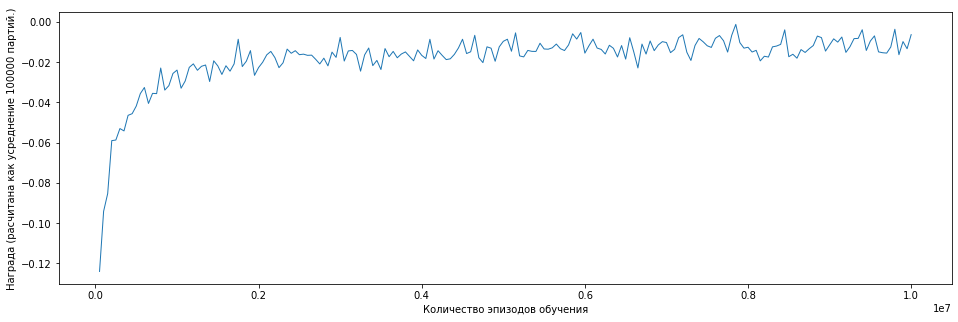


Off-policy TD control (Q learning)
-0.00409 train episods=10000000 game episods=100000 alpha=1e-07 gamma=0.8 epsilon=0.95


In [6]:
env = jack_countdeck.BlackjackEnv(natural=True)
epsilon = 0.95
alpha = 1e-07
gamma = 0.8
episods_train = 10000000
episods_game = 100000
qmodel = TDcontrol(env, epsilon, alpha, gamma)

qmodel.train(episods_train, show_plots = True)
rew,_ = qmodel.game(episods_game)
print("Off-policy TD control (Q learning)")
print(f"{rew} train episods={episods_train} game episods={episods_game} alpha={alpha} gamma={gamma} epsilon={epsilon}")